![](images/2021-07-31-music-shop.jfif){fig-align="center"}

<center><a href = "https://unsplash.com/photos/fEVaiLwWvlU">Unsplash | Clay Banks</a></center>

# Overview

The [Chinook database](https://github.com/lerocha/chinook-database) by Luis Rocha and Brice Lambson is a sample database about a hypothetical digital media store called Chinook. This store sells individual music tracks online, similar to iTunes. The database contains tables covering various aspects of the company, such as the employees, customers, invoices, tracks, albums, and artists.

The schema below, which was designed by Dataquest, lists the columns under each table. Columns connected by lines contain **matching information**.

![](images/chinook-schema-dataquest.png){fig-align="center"}

<center><a href = "https://app.dataquest.io/c/46/m/191/guided-project%3A-answering-business-questions-using-sql/1/introduction-and-schema-diagram">Image from Dataquest Guided Project: Answering Business Questions Using SQL</a></center>

<br/>

The matching columns allow us to perform joins on these tables. Thus, we are able to answer more complicated questions about the data.

In our hypothetical scenario, the Chinook company has requested us to answer the following business questions:

- What are the best-selling music genres with regards to USA customers? Based on this, which new albums should be purchased for the Chinook store?
- Which of Chinook's sales support agents has the highest total sales from their assigned customers? Can the exemplary performance of these employees be explained by any information in the database?
- What are the statistics on the customers and sales for each country where Chinook offers its service?
- How many purchases are full albums, and how many are selected sets of tracks? Based on this, what strategy should Chinook adopt when buying new tracks from record companies?

SQL will be used to answer all of these questions. Matplotlib and Altair will also be used to produce helpful visualizations.

:::{.callout-note}

I wrote this notebook by following a guided project on the [Dataquest](https://www.dataquest.io/) platform, specifically the [Guided Project: Answering Business Questions Using SQL](https://app.dataquest.io/c/46/m/191/guided-project%3A-answering-business-questions-using-sql/1/introduction-and-schema-diagram). The general project flow and research questions came from Dataquest. However, the text and code here are written by me unless stated otherwise.

:::

# Preparations

Install the necessary packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

Connect to the database using SQLite.

In [2]:
%load_ext sql
%sql sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db

'Connected: @private/2021-07-31-Intermediate-SQL-Files/chinook.db'

# Analysis

## Tables and Views

First, we'll inspect the tables and views available in the `chinook.db` database.

- Tables contain columns of data. Each column has a different name and data type.
- Views do not contain data. Instead, these are pre-written SQL queries which show a transformation of existing data. Thus, it can be called a "virtual table." ([Sławińska 2020](https://learnsql.com/blog/sql-view/))

In [3]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table", "view")
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


Originally, there were only 11 tables and 0 views in the database. The views listed above are ones which I made throughout this project. I will show how I created these views in later sections.

For now, let's inspect the `customer` table, as we will be using it to answer most of the company's business questions.

In [4]:
%%sql
SELECT *
FROM customer
LIMIT 5
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.


customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4
5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4


Each row in this table contains data on a different customer of Chinook. Each customer has a unique customer ID and an assigned support representative from Chinook. The support rep's employee ID is stored in the `support_rep_id` column. The other columns contain information on the customer's name, occupation, location, and contact details.

:::{.callout-note}

All names and personal details in the Chinook database are fictitious and randomly generated. Public use of this database is not a breach of data privacy.

:::

## Best-Selling Music Genres in the USA

In our first scenario, Chinook has signed a deal with a new record company, so its tracks can now be put up for sale on the Chinook store. The record company has 4 albums so far; below are the artist names and their genres.

- Regal (Hip-Hop)
- Red Tone (Punk)
- Meteor and the Girls (Pop)
- Slim Jim Bites (Blues)

However, Chinook would like to spread its releases over time, so it will only add 3 albums to the store. Thus, we have to determine the best-selling genres on the store. Furthermore, since the record company would like to target a USA audience, we can narrow our analysis to Chinook's USA customers.

First, we create a view called `usa_track_purchases`. This will show the genre, track name, unit price, and quantity bought for each of the invoice lines of USA customers.

In [5]:
%%sql
DROP VIEW IF EXISTS usa_track_purchases;

CREATE VIEW usa_track_purchases AS
    SELECT
        il.invoice_line_id AS invoice_line_id,
        g.name AS genre,
        t.name AS track_name,
        il.unit_price AS unit_price,
        il.quantity AS quantity
    FROM customer AS c
    INNER JOIN
        invoice AS iv
        ON iv.customer_id = c.customer_id
    INNER JOIN
        invoice_line AS il
        ON il.invoice_id = iv.invoice_id
    INNER JOIN
        track AS t
        ON t.track_id = il.track_id
    INNER JOIN
        genre AS g
        ON g.genre_id = t.genre_id
    WHERE c.country = "USA"
;

SELECT *
FROM usa_track_purchases
LIMIT 7
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Done.
Done.


invoice_line_id,genre,track_name,unit_price,quantity
1,Rock,Right Next Door to Hell,0.99,1
2,Rock,Dust N' Bones,0.99,1
3,Rock,Live and Let Die,0.99,1
4,Rock,Don't Cry (Original),0.99,1
5,Rock,Perfect Crime,0.99,1
6,Rock,You Ain't the First,0.99,1
7,Rock,Bad Obsession,0.99,1


By querying the view above, we will create another view, `usa_genre_sales`. This will contain the following specific information about each genre:

- Number of tracks sold
- Percentage of tracks sold
- Total sales in US dollars

In [6]:
%%sql 
DROP VIEW IF EXISTS usa_genre_sales;

CREATE VIEW usa_genre_sales AS
    SELECT
        genre,
        
        SUM(quantity) AS number_sold,
        
        --Get the quantity per genre and divide it by the total quantity of USA purchases.
        ROUND(
            CAST(SUM(quantity) AS Float)
            / CAST(
                (SELECT COUNT(*) FROM usa_track_purchases)
                AS Float
            )
            * 100.0,
            2
        ) AS percentage_sold,
        
        ROUND(
            SUM(unit_price * CAST(quantity AS Float)),
            2
        ) AS total_sales
        
    FROM usa_track_purchases
    GROUP BY genre
    ORDER BY number_sold DESC, total_sales DESC
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Done.


[]

In [7]:
%%sql result <<
SELECT *
FROM usa_genre_sales
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Returning data to local variable result


In [8]:
usa_genre_df = result.DataFrame()
usa_genre_df

,genre,number_sold,percentage_sold,total_sales
0,Rock,561,53.38,555.39
1,Alternative & Punk,130,12.37,128.70
2,Metal,124,11.80,122.76
3,R&B/Soul,53,5.04,52.47
4,Blues,36,3.43,35.64
5,Alternative,35,3.33,34.65
6,Latin,22,2.09,21.78
7,Pop,22,2.09,21.78
8,Hip Hop/Rap,20,1.90,19.80
9,Jazz,14,1.33,13.86


We can make a bar graph from this result in order to communicate findings better.

In [9]:
#| code-fold: true
(
    alt.Chart(usa_genre_df)
    .mark_bar()
    .encode(
        x = alt.X("genre:N", title = "Music Genre", sort = "-y"),
        y = alt.Y("percentage_sold:Q", title = "Percentage of All Purchases in the USA"),
        color = alt.Color("total_sales:Q", title = "Total Sales (USD)"),
        tooltip = usa_genre_df.columns.tolist(),
    )
    .properties(
        title = "Popularity of Music Genres with Chinook's USA Customers",
        height = 300,
        width = 600,
    )
    .configure_axis(
        labelAngle = 30,
    )
    .interactive()
)

alt.Chart(...)

One can hover over each bar in the chart above for a tooltip with more specific information.

Results show that Rock is the best-selling music genre as it makes up 53% of total purchases in the USA. Rock is followed by the Alternative & Punk and Metal genres, which each make up over 10% of purchases.

On a side note, the `total_sales` column's values are very close to that of the `number_sold` column. This can be explained by the fact that track prices range from USD 0.99 to USD 1.99.

In [10]:
%%sql
SELECT
    MIN(unit_price) AS min_price,
    MAX(unit_price) AS max_price
FROM track
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.


min_price,max_price
0.99,1.99


Since there is little variation among track prices, the genre with the most units sold is usually also the genre with the highest sales.

Going back to the scenario at hand, we need to compare the statistics on the Hip-Hop, Punk, Pop, and Blues genres. We will run a query for this below.

In [11]:
%%sql
SELECT *
FROM usa_genre_sales
WHERE genre IN ("Hip Hop/Rap", "Alternative & Punk", "Pop", "Blues")
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.


genre,number_sold,percentage_sold,total_sales
Alternative & Punk,130,12.37,128.7
Blues,36,3.43,35.64
Pop,22,2.09,21.78
Hip Hop/Rap,20,1.9,19.8


The result above shows that Alternative & Punk, Blues, and Pop are the three best-selling genres out of the four. Notably, Alternative & Punk makes up 12.37% of all purchases in the USA.

Therefore, we would recommend the Chinook administration to add the albums of **Red Tone (Punk), Slim Jim Bites (Blues), and Meteor and the Girls (Pop)** to the digital store. The album of Regal (Hip-Hop) has lower priority and can be added at a later date.

## Sales Support Agent Performance

Next, Chinook is requesting us to evaluate the performance of its sales support agents. Each customer is assigned to an agent after their first purchase. Since there are only 3 agents, each agent provides support to many customers. Details about the agents are shown in the query below.

In [12]:
%%sql
SELECT *
FROM employee
WHERE title = "Sales Support Agent"
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.


employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
4,Park,Margaret,Sales Support Agent,2,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com


Since we have data on each customer's purchases, we can calculate the total purchases associated with each support agent. We can then use this to compare the performance of the agents.

First, we create a view called `agent_customer` by joining the `employee` table with the `customer` table based on the support representative ID. We will include some extra details about each agent, such as their birthdate and hire date. We won't include their location since we know that they are all in Calgary, AB, Canada. As for the customers, we will include their customer ID, name, and total purchases as the sum of their invoices.

In [13]:
%%sql
DROP VIEW IF EXISTS agent_customer;

CREATE VIEW agent_customer AS
    SELECT
        e.employee_id AS agent_id,
        e.first_name || " " || e.last_name AS agent_name,
        e.birthdate AS agent_bd,
        e.hire_date AS agent_hire_date,
        c.customer_id AS customer_id,
        c.first_name || " " || c.last_name AS customer_name,
        SUM(iv.total) AS customer_total_purchases
    FROM employee AS e
    LEFT JOIN
        customer AS c
        ON c.support_rep_id = e.employee_id
    LEFT JOIN
        invoice AS iv
        ON iv.customer_id = c.customer_id
    WHERE e.title = "Sales Support Agent"
    GROUP BY c.customer_id
    ORDER BY agent_id, customer_id
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Done.


[]

In [14]:
%%sql result <<
SELECT *
FROM agent_customer
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Returning data to local variable result


In [15]:
agent_customer_df = result.DataFrame()
agent_customer_df.head()

,agent_id,agent_name,agent_bd,agent_hire_date,customer_id,customer_name,customer_total_purchases
0,3,Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,1,Luís Gonçalves,108.90
1,3,Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,3,François Tremblay,99.99
2,3,Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,12,Roberto Almeida,82.17
3,3,Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,15,Jennifer Peterson,66.33
4,3,Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,18,Michelle Brooks,79.20


Next, we will query this view in order to determine the following information about each agent:

- number of customers
- total sales from the agent's customers
- percentage of all agents' sales
- average sales per customer

In [16]:
%%sql
DROP VIEW IF EXISTS agent_stats;

CREATE VIEW agent_stats AS
    SELECT
        agent_id,
        agent_name,
        agent_bd,
        agent_hire_date,
        COUNT(customer_id) AS number_customers,
        ROUND(
            SUM(customer_total_purchases),
            2
        ) AS sales_number,
        ROUND(
            SUM(customer_total_purchases) 
            / (SELECT SUM(customer_total_purchases) FROM agent_customer)
            * 100,
            2
        )AS sales_percentage,
        ROUND(
            AVG(customer_total_purchases),
            2
        ) AS average_per_customer
    FROM agent_customer
    GROUP BY agent_id
;

SELECT *
FROM agent_stats
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Done.
Done.


agent_id,agent_name,agent_bd,agent_hire_date,number_customers,sales_number,sales_percentage,average_per_customer
3,Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,21,1731.51,36.77,82.45
4,Margaret Park,1947-09-19 00:00:00,2017-05-03 00:00:00,20,1584.0,33.63,79.2
5,Steve Johnson,1965-03-03 00:00:00,2017-10-17 00:00:00,18,1393.92,29.6,77.44


At first glance, Jane Peacock seems like the best-performing agent since Chinook got the highest total sales from her customers (USD 1731.51). This idea is cast into doubt when it is mentioned that she had the highest number of customers (21).

Also, the differences among the average sales per customer is quite small. Each of Jane's customers spends 3 more dollars on Chinook than each of Margaret's. Each of Margaret's customers spends 2 more dollars on Chinook than each of Steve Johnson's.

The average sales per customer may also be influenced by outliers, as shown by the boxplot below.

In [17]:
#| code-fold: true
(
    alt.Chart(agent_customer_df)
    .mark_boxplot()
    .encode(
        y = alt.Y("customer_total_purchases:Q", title = "Customer Total Purchases"),
        x = alt.X("agent_name:N", title = "Agent Name"),
    )
    .properties(
        title = "Distribution of Customer Purchases by Sales Support Agent",
        height = 300,
        width = 500,
    )
    .interactive()
)

alt.Chart(...)

If we hover over each of the boxes above, we can get more information such as minimum, 1st quartile, median, etc. The median is less influenced by outliers, so we can look at that. The median values are 79.20 (Jane), 77.72 (Margaret), and 75.74 (Steve). These values are still very close to each other.

Therefore, we cannot conclusively state that any agent performs better than the others.

## Sales Data by Country

Next, Chinook is requesting us to analyze sales in each country where it offers its service. Specifically, they would like to know the:

- total number of customers
- total value of sales
- average sales per customer
- average order value
    - Every order is a batch purchase of multiple tracks.
    
Furthermore, since there are some countries in the database with only one customer, we shall group these customers together under a category called "Other", which must appear at the very bottom of our final result.

First, we will create a view, `country_invoices`, which shows all invoices and the country of the customer.

In [18]:
%%sql
DROP VIEW IF EXISTS country_invoices;

CREATE VIEW country_invoices AS
    SELECT
        c.country AS country,
        c.customer_id AS customer_id,
        c.first_name || " " || c.last_name AS customer_name,
        iv.invoice_id AS invoice_id,
        iv.total AS order_value
    FROM customer AS c
    LEFT JOIN
        invoice AS iv
        ON iv.customer_id = c.customer_id
;

SELECT *
FROM country_invoices
LIMIT 5
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Done.
Done.


country,customer_id,customer_name,invoice_id,order_value
Brazil,1,Luís Gonçalves,16,8.91
Brazil,1,Luís Gonçalves,77,5.9399999999999995
Brazil,1,Luís Gonçalves,149,8.91
Brazil,1,Luís Gonçalves,153,13.86
Brazil,1,Luís Gonçalves,182,5.9399999999999995


Then, we will create a view, `country_customers`, which shows the total purchases per customer.

In [19]:
%%sql
DROP VIEW IF EXISTS country_customers;

CREATE VIEW country_customers AS
    SELECT
        country,
        customer_id,
        customer_name,
        SUM(order_value) AS customer_total_purchase
    FROM country_invoices
    GROUP BY customer_id
;

SELECT *
FROM country_customers
LIMIT 5
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Done.
Done.


country,customer_id,customer_name,customer_total_purchase
Brazil,1,Luís Gonçalves,108.89999999999998
Germany,2,Leonie Köhler,82.17
Canada,3,François Tremblay,99.99
Norway,4,Bjørn Hansen,72.27000000000001
Czech Republic,5,František Wichterlová,144.54000000000002


We will then create a view called `country_labels`. It will show the number of customers per country. Countries with only 1 customer will be given a label of "Other".

In [20]:
%%sql
DROP VIEW IF EXISTS country_labels;

CREATE VIEW country_labels AS
    SELECT
        country,
        COUNT(customer_id) AS number_customers,
        CASE
            WHEN COUNT(customer_id) > 1 THEN country
            ELSE "Other"
            END AS country_label,
        CASE
            WHEN COUNT(customer_id) > 1 THEN 0
            ELSE 1
            END AS is_other
    FROM country_customers
    GROUP BY country
;

SELECT *
FROM country_labels
LIMIT 10
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Done.
Done.


country,number_customers,country_label,is_other
Argentina,1,Other,1
Australia,1,Other,1
Austria,1,Other,1
Belgium,1,Other,1
Brazil,5,Brazil,0
Canada,8,Canada,0
Chile,1,Other,1
Czech Republic,2,Czech Republic,0
Denmark,1,Other,1
Finland,1,Other,1


We will also create a view called `country_avg_order` which simply shows the average order value per country. This will be done by querying the `country_invoices` view.

In [21]:
%%sql
DROP VIEW IF EXISTS country_avg_order;

CREATE VIEW country_avg_order AS
    SELECT
        cl.country_label,
        AVG(civ.order_value) AS avg_order_value
    FROM country_invoices AS civ
    INNER JOIN
        country_labels AS cl
        ON cl.country = civ.country
    GROUP BY cl.country_label
;

SELECT *
FROM country_avg_order
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Done.
Done.


country_label,avg_order_value
Brazil,7.011147540983605
Canada,7.047236842105264
Czech Republic,9.107999999999999
France,7.781400000000001
Germany,8.161463414634145
India,8.72142857142857
Other,7.44857142857143
Portugal,6.3837931034482756
USA,7.942671755725194
United Kingdom,8.768571428571429


Finally, we will create a view called `country_stats` that shows all of the 4 statistics that were requested by the Chinook management. The "Other" entry will be forced to the bottom of the query result using the `is_other` column we created in the `country_labels` view.

In [22]:
%%sql
DROP VIEW IF EXISTS country_stats;

CREATE VIEW country_stats AS
    SELECT
        l.country_label,
        COUNT(c.customer_id) AS number_customers,
        ROUND(SUM(c.customer_total_purchase), 2) AS total_sales,
        ROUND(AVG(c.customer_total_purchase), 2) AS avg_sales_customer,
        ROUND(a.avg_order_value, 2) AS avg_order_value
    FROM country_customers AS c
    INNER JOIN
        country_labels AS l
        ON l.country = c.country
    INNER JOIN
        country_avg_order AS a
        ON a.country_label = l.country_label
    GROUP BY l.country_label
    ORDER BY
        l.is_other ASC,
        total_sales DESC
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Done.


[]

In [23]:
%%sql result <<
SELECT *
FROM country_stats
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Returning data to local variable result


In [24]:
country_stats_df = result.DataFrame()
country_stats_df

,country_label,number_customers,total_sales,avg_sales_customer,avg_order_value
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.57,6.38
8,India,2,183.15,91.58,8.72
9,Other,15,1094.94,73.00,7.45


We can make a scatter plot with the data above in order to make results more clear.

In [25]:
#| code-fold: true
# Exclude the "Other" entry.
main_df = country_stats_df.loc[country_stats_df["country_label"] != "Other"]

# Base layer.
base = (
    alt.Chart(main_df)
    .mark_point(size = 300) # Set default size of points to 300 pixels.
    .encode(
        x = alt.X("number_customers:Q", title = "Number of Customers"),
        y = alt.Y("total_sales:Q", title = "Total Sales (USD)"),
    )
)

# Scatter plot layer.
points = base.encode(
    color = alt.Color("avg_sales_customer:Q", title = "Average Sales per Customer (USD)"),
    tooltip = country_stats_df.columns.tolist(),
)

# Text layer.
text = (
    base
    .mark_text( # Move text to the top left of each point.
        align = "right",
        dy = -5,
        dx = -20,
    )
    .encode(
        text = "country_label:N"
    )
)

# Combine layers.
chart = (
    (points + text)
    .properties(
        title = "Chinook Sales by Country",
        height = 300,
        width = 700,
    )
    .interactive()
)

# Display chart.
chart

alt.LayerChart(...)

Looking at the top right of the chart, we can see that the USA has the highest number of Chinook customers (13), as well as the highest total sales (USD 1040.49). All of the other countries have only 2 to 8 customers.

On the other hand, the Czech Republic has the highest average sales per customer at USD 136.62; this is indicated by its dark color in the chart. This country also had the highest average order value at USD 9.11. This means that though the country has few customers, these people are avid buyers of music.

Chinook may benefit from marketing its service more aggressively in countries other than the USA where it has gained a good foothold, such as **Canada, Brazil, and France**. Chinook may also target the **Czech Republic** since the customers there seem to buy a lot of music on a per-person basis.

## Comparing Purchase Types: Full Album vs Selected Sets

In our last scenario, we have been requested to compare the popularities of Chinook's two purchase types:

- Full album
    - The customer buys a full album.
    - Albums are pre-defined in Chinook's library. The customer may not add other tracks on top of an album.
- Selected set of tracks
    - The customer manually selects any number of individual tracks.

In both cases, each track is bought at its unit price; there are no discounts.

Currently, Chinook's purchasing strategy is to **buy full albums** from record companies. However, Chinook doesn't know whether full album purchases are popular among its customers. If selected sets are more popular, then Chinook may switch to a new strategy in which it will only **buy the most popular individual tracks** from record companies.

Our analysis will help Chinook make the final decision. For each purchase type, we will show the number of invoices and percentage of all invoices with that type. The type with the higher number will be the more popular one.

First, we create a view, `invoice_tracks`, that shows all tracks under each invoice. The album associated with each track is also shown.

In [26]:
%%sql
DROP VIEW IF EXISTS invoice_tracks_bought;

CREATE VIEW invoice_tracks_bought AS
    SELECT
        iv.invoice_id AS invoice_id,
        il.track_id AS track_id,
        t.name AS track_name,
        t.album_id AS album_id,
        a.title AS album_name
    FROM invoice AS iv
    INNER JOIN
        invoice_line AS il
        ON il.invoice_id = iv.invoice_id
    INNER JOIN
        track AS t
        ON t.track_id = il.track_id
    INNER JOIN
        album AS a
        ON a.album_id = t.album_id
    ORDER BY invoice_id, track_id, album_id
;

SELECT *
FROM invoice_tracks_bought
LIMIT 7
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Done.
Done.


invoice_id,track_id,track_name,album_id,album_name
1,1158,Right Next Door to Hell,91,Use Your Illusion I
1,1159,Dust N' Bones,91,Use Your Illusion I
1,1160,Live and Let Die,91,Use Your Illusion I
1,1161,Don't Cry (Original),91,Use Your Illusion I
1,1162,Perfect Crime,91,Use Your Illusion I
1,1163,You Ain't the First,91,Use Your Illusion I
1,1164,Bad Obsession,91,Use Your Illusion I


Then, we create a view called `invoice_album`, which shows only the album associated with the first track of each invoice. This way, there is only **one row per invoice**. We will also include the total purchase amount of each invoice so that we can use it later.

In [27]:
%%sql
DROP VIEW IF EXISTS invoice_album;

CREATE VIEW invoice_album AS 
    SELECT
        itb.invoice_id AS invoice_id,
        MIN(itb.album_id) AS album_id,
        itb.album_name AS album_name,
        iv.total AS total_purchase
    FROM invoice_tracks_bought AS itb
    INNER JOIN
        invoice AS iv
        ON iv.invoice_id = itb.invoice_id
    GROUP BY itb.invoice_id
    ORDER BY itb.invoice_id
;

SELECT *
FROM invoice_album
LIMIT 5
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Done.
Done.


invoice_id,album_id,album_name,total_purchase
1,91,Use Your Illusion I,15.84
2,20,The Best Of Buddy Guy - The Millenium Collection,9.9
3,203,A-Sides,1.98
4,58,Come Taste The Band,7.92
5,163,From The Muddy Banks Of The Wishkah [live],16.83


Then, we join `invoice_album` with the `track` table in order to **list all of the tracks** under the album associated with each invoice. The result will be a view called `invoice_full_album_tracks`.

In [28]:
%%sql
DROP VIEW IF EXISTS invoice_full_album_tracks;

CREATE VIEW invoice_full_album_tracks AS
    SELECT
        ia.*,
        t.track_id AS track_id,
        t.name AS track_name
    FROM invoice_album AS ia
    INNER JOIN
        track AS t
        ON t.album_id = ia.album_id
    ORDER BY invoice_id, album_id, track_id
;

SELECT *
FROM invoice_full_album_tracks
LIMIT 5
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Done.
Done.


invoice_id,album_id,album_name,total_purchase,track_id,track_name
1,91,Use Your Illusion I,15.84,1158,Right Next Door to Hell
1,91,Use Your Illusion I,15.84,1159,Dust N' Bones
1,91,Use Your Illusion I,15.84,1160,Live and Let Die
1,91,Use Your Illusion I,15.84,1161,Don't Cry (Original)
1,91,Use Your Illusion I,15.84,1162,Perfect Crime


The `invoice_full_album_tracks` view looks very similar to the `invoice_tracks_bought` view at first glance. However, there is a difference:

- `invoice_tracks_bought`
    - It contains the tracks **bought** in each invoice.
    - Each set of tracks may or may not be a full album.
- `invoice_full_album_tracks`
    - It contains all of the tracks under one album associated with an invoice.
    - Some of these tracks **may not have been bought** by the customer.
    
Next, we will create a new view called `invoice_purchase_type` which indicates whether each invoice is a "Full Album" or "Selected Set" purchase.

In order to determine this, we will have a `CASE` statement which can be explained as follows:

- `WHEN` clause: If the set of tracks bought and the full album are **exactly the same**, mark the purchase type as "Full Album".
- `ELSE` clause: Otherwise, mark the purchase type as "Selected Set".

Inside the `WHEN` clause, we have a rather complicated-looking set of operations. Let's look at one part:

    (
        SELECT itb.track_id
        FROM invoice_tracks_bought AS itb
        WHERE itb.invoice_id = ia.invoice_id

        EXCEPT

        SELECT ifa.track_id
        FROM invoice_full_album_tracks AS ifa
        WHERE ifa.invoice_id = ia.invoice_id
    ) IS NULL
    
In order to make the explanation more simple, we can call the subqueries above "set 1" and "set 2".

    (
        {set 1}

        EXCEPT

        {set 2}
    ) IS NULL
    
- Set 1 represents all tracks bought in one invoice.
- Set 2 represents the full set of tracks in an album associated with the invoice.
- Via `EXCEPT` and `IS NULL`, we check whether Set 1 is a subset of Set 2.
    - If it is, the result is True.
    - Otherwise, False.

We then repeat the same process but *in reverse*, to check if Set 2 is a subset of Set 1. We thus end up with *two boolean values*, and we use the `AND` operator on these.

    (
        {set 1}

        EXCEPT

        {set 2}
    ) IS NULL

    AND

    (
        {set 2}

        EXCEPT

        {set 1}
    ) IS NULL

The purpose of `AND` is to determine the following.

- If both conditions are True:
    - The two sets of tracks match exactly.
    - The invoice is a "Full Album" purchase.
- If any condition is False:
    - The two sets of tracks do not match exactly.
    - The invoice is a "Selected Set" purchase.
    
The full query is shown below.

In [29]:
%%sql
DROP VIEW IF EXISTS invoice_purchase_type;

CREATE VIEW invoice_purchase_type AS
    SELECT
        ia.invoice_id,
        CASE
            WHEN (

                (
                    SELECT itb.track_id
                    FROM invoice_tracks_bought AS itb
                    WHERE itb.invoice_id = ia.invoice_id

                    EXCEPT

                    SELECT ifa.track_id
                    FROM invoice_full_album_tracks AS ifa
                    WHERE ifa.invoice_id = ia.invoice_id
                ) IS NULL

                AND

                (
                    SELECT ifa.track_id
                    FROM invoice_full_album_tracks AS ifa
                    WHERE ifa.invoice_id = ia.invoice_id

                    EXCEPT

                    SELECT itb.track_id
                    FROM invoice_tracks_bought AS itb
                    WHERE itb.invoice_id = ia.invoice_id
                ) IS NULL

            ) THEN "Full Album"
            ELSE "Selected Set"
            END AS purchase_type,
        ia.total_purchase AS total_purchase
    FROM invoice_album AS ia
;

SELECT *
FROM invoice_purchase_type
LIMIT 10
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Done.
Done.


invoice_id,purchase_type,total_purchase
1,Full Album,15.84
2,Selected Set,9.9
3,Selected Set,1.98
4,Selected Set,7.92
5,Full Album,16.83
6,Selected Set,1.98
7,Selected Set,10.89
8,Selected Set,9.9
9,Selected Set,8.91
10,Selected Set,1.98


With the view above, we can finally answer the question being asked. A view called `purchase_type_proportion` will be created which shows the following information per purchase type:

- number of invoices
- percentage of invoices
- average sales per invoice
- sales in USD
- percentage of total sales

In [30]:
%%sql
DROP VIEW IF EXISTS purchase_type_proportion;

CREATE VIEW purchase_type_proportion AS
    SELECT
        purchase_type,
        
        COUNT(purchase_type) AS type_count,
        
        ROUND(
            CAST(COUNT(purchase_type) AS Float)
            / CAST(
                (SELECT COUNT(purchase_type)
                 FROM invoice_purchase_type)
                AS Float
            )
            * 100,
            2
        ) AS type_percentage,
        
        ROUND(
            AVG(total_purchase),
            2
        ) AS avg_sales_per_invoice,
        
        ROUND(
            SUM(total_purchase),
            2
        ) AS sales_number,
        
        ROUND(
            SUM(total_purchase)
            / (SELECT SUM(total_purchase)
               FROM invoice_purchase_type)
            * 100,
            2
        ) AS sales_percentage
        
    FROM invoice_purchase_type
    GROUP BY purchase_type
    ORDER BY type_count DESC
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Done.


[]

In [31]:
%%sql result <<
SELECT *
FROM purchase_type_proportion
;

 * sqlite:///private/2021-07-31-Intermediate-SQL-Files/chinook.db
Done.
Returning data to local variable result


In [32]:
purchase_type_df = result.DataFrame()
purchase_type_df

,purchase_type,type_count,type_percentage,avg_sales_per_invoice,sales_number,sales_percentage
0,Selected Set,500,81.43,6.50,3248.19,68.97
1,Full Album,114,18.57,12.82,1461.24,31.03


The `type_percentage` column shows that the majority (81%) of all Chinook invoices are Selected Sets. Full Album purchases only make up 19% of all invoices.

This is shown in the pie chart below.

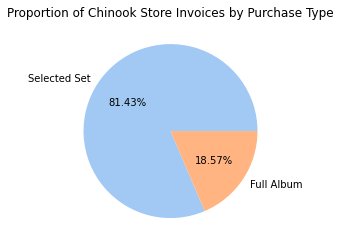

In [33]:
#| code-fold: true
colors = sns.color_palette('pastel')[:2]

plt.pie(
    x = purchase_type_df["type_percentage"],
    labels = purchase_type_df["purchase_type"],
    colors = colors,
    autopct = "%0.2f%%",
)

plt.title("Proportion of Chinook Store Invoices by Purchase Type")

plt.show()

However, the average sales per Full Album purchase is *almost twice* that of a Selected Set purchase. This is shown in the bar chart below.

In [34]:
#| code-fold: true
# Base layer with bar chart
base = (
    alt.Chart(purchase_type_df)
    .mark_bar()
    .encode(
        x = alt.X("purchase_type:N", title = "Purchase Type"),
        y = alt.Y("avg_sales_per_invoice:Q", title = "Average Sales per Invoice (USD)"),
        tooltip = purchase_type_df.columns.tolist(),
    )
)

# Text layer
text = (
    base
    .mark_text(
        align = "center",
        dy = 10,
        color = "white",
    )
    .encode(
        text = "avg_sales_per_invoice:Q",
    )
)

# Combine layers into one chart
chart = (
    (base + text)
    .properties(
        title = "Average Sales per Invoice by Purchase Type",
        height = 300,
        width = 200,
    )
    .configure_axis(labelAngle = 30)
    .interactive()
)

# Display chart.
chart

alt.LayerChart(...)

Full Albums cost more than Selected Sets because the former tend to have more tracks. Thus, even if Full Albums only represent 19% of all invoices, these also represent *31% of all dollar sales*. This is shown in the pie chart below.

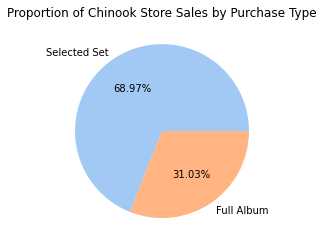

In [35]:
#| code-fold: true
plt.pie(
    x = purchase_type_df["sales_percentage"],
    labels = purchase_type_df["purchase_type"],
    colors = colors,
    autopct = "%0.2f%%",
)

plt.title("Proportion of Chinook Store Sales by Purchase Type")

plt.show()

Overall, though, Selected Sets still represent the majority of Chinook's invoices (81%) and sales (69%). Therefore, we recommend that Chinook shift to a new purchasing strategy in which it **only buys the most popular tracks** from record companies. Chinook should not buy full albums since it is less likely for customers to purchase these.

# Conclusion

In this project, we used intermediate SQL techniques to answer business questions for a hypothetical digital media store called Chinook. We solved a total of 4 scenarios by creating views and gradually working towards a final query. We also ended each scenario with a chart that communicates our findings more engagingly.

Below is a summary of all of the questions and our findings.

<br/>

*What are the best-selling music genres with regards to USA customers? Based on this, which new albums should be purchased for the Chinook store?*

Rock is the best-selling music genre as it makes up 53% of total purchases in the USA. Rock is followed by the Alternative & Punk genre and Metal genre, which each make up over 10% of purchases.

Among the 4 new albums which may be added to the digital store, we recommend the following 3 artists' albums: Red Tone (Punk), Slim Jim Bites (Blues), and Meteor and the Girls (Pop).

<br/>

*Which of Chinook's sales support agents has the highest total sales from their assigned customers? Can the exemplary performance of these employees be explained by any information in the database?*

Sales support agent Jane Peacock has the highest total sales (37% of all sales) from her customers. She also has the highest average sales per customer (USD 82).

However, her statistics are only slightly higher than that of her colleagues. Therefore, we cannot conclusively say that she is the best-performing agent.

<br/>

*What are the statistics on the customers and sales for each country where Chinook offers its service?*

The USA has the highest number of Chinook customers (13), as well as the highest total sales (USD 1040.49). All of the other countries have only 2 to 8 customers.

We recommend marketing Chinook more aggressively in Canada, Brazil, and France since these countries have the highest number of customers after the USA. We also recommend expanding into the Czech Republic since it has a high average value of sales per customer.

<br/>

*How many purchases are full albums, and how many are manually selected sets of tracks? Based on this, what strategy should Chinook adopt when buying new tracks from record companies?*

Selected Sets account for 81% of all invoices and 69% of total sales. Therefore, these are more popular than Full Albums.

Thus, we recommend that Chinook buy only the most popular tracks from record companies. This would be more cost-effective than buying full albums.

---

That concludes this project. Thanks for reading!